##### PyMC3 Examples

# NUTS scaling using ADVI Outputs

#### A minimal reproducable example of using the stdevs of ADVI to set the scaling matrix of the NUTS sampler.



I caught up with [Thomas Wiecki](https://twiecki.github.io) after his talk at [ODSC London](https://www.odsc.com/london) and he mentioned a potential speed increase for NUTS sampling by using ADVI outputs to set the covariance scaling matrix.

This seems like a great idea and there's already a [good example in the docs](http://pymc-devs.github.io/pymc3/notebooks/stochastic_volatility.html#Fit-Model) but I wanted to try it myself, and get a feel for the speed increase.


### Overview

In this Notebook I generate a small, noisy dataset according to a simple linear model, and attempt to recover the parameters comparing 3 techniques:

1. NUTS, initialised at model test point (zero, the basic choice)
2. NUTS, initialised at mean ADVI (my default choice to date)
3. NUTS, initialised at mean ADVI, and scaling the covariance with the ADVI stdev (hopefully a speed increase)


### Results Summary

The final estimates of the model parameter coeffs look quite similar, and close to the correct values. Each NUTS sampler was run for the same count of traces, yet they took quite different times to sample, since the quality of exploration was different:

1. NUTS, initialised at test point zero: 9 sec, 
2. NUTS, initialised at mean ADVI: 163 sec
3. NUTS, initialised at mean ADVI, and scaled using ADVI stdevs: 3 sec

The scaling really seems to help speed up the NUTS sampling: the traces appear to converge much more quickly and seem more settled. The parameter estimates are good too.

_**In general, it seems worth trying to set the NUTS scaling using ADVI stdevs.**_


### Contents


+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Generate Data](#Generate-Data)


+ [Create and Test Linear Model](#Create-and-Test-Linear-Model)
    + [Metropolis Sampling](#Metropolis-Sampling)
    + [ADVI Estimation](#ADVI-Estimation)


+ [Test NUTS Sampling](#Test-NUTS-Sampling)
    + [1. NUTS initialise MAP using Powell](#1.-NUTS-initialise-MAP-using-Powell)
    + [2. NUTS initialise MAP using ADVI mean](#2.-NUTS-initialise-MAP-using-ADVI-mean)
    + [3. NUTS initialise MAP using ADVI mean and scale using ADVI stdevs](#3.-NUTS-initialise-MAP-using-ADVI-mean-and-scale-using-ADVI-stdevs)
    
    
    
### Package Requirements (shown as a conda-env YAML):
```
$> less conda_env_pymc3_examples.yml

name: pymc3_examples
channels:
  - defaults
dependencies:
    - python=3.5
    - jupyter
    - ipywidgets
    - numpy
    - scipy
    - matplotlib
    - pandas
    - pip
    - pip:
        - watermark
        - pymc3        

$> conda env create --file conda_env_pymc3_examples.yml
$> source activate pymc3_examples
```

# Setup

In [1]:
%matplotlib inline
%qtconsole --colors=Linux

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = 12, 4
rndst = np.random.RandomState(0)

%load_ext watermark
%watermark -dmvgp numpy,pandas,matplotlib,pymc3,theano,joblib

2016-10-18 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.2
pymc3 3.0.rc1
theano 0.8.2
joblib 0.10.2

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 14.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : f737bf97f29670725f5ef2824e70585ee3feefd6


## Local Functions

In [3]:
def generate_data(n=20, p=0, a=1, b=1, c=0, latent_sigma_y=20):
    ''' 
    Create a toy dataset based on a very simple model that we might
    imagine is a noisy physical process:
        1. random x values within a range
        2. latent error aka inherent noise in y
        3. optionally create labelled outliers with larger noise

    Model form: y ~ a + bx + cx^2 + e
    
    NOTE: latent_sigma_y is used to create a normally distributed,
    'latent error' aka 'inherent noise' in the 'physical process' 
    generating thses values, rather than experimental measurement error. 
    Please don't use the returned `latent_error` values in inferential 
    models, it's returned in e dataframe for interest only.
    '''
    rndst = np.random.RandomState(0)
    
    df = pd.DataFrame({'x':rndst.choice(np.arange(max(100, 2*n)), n, replace=False)})
                
    ## create linear or quadratic model
    df['y'] = a + b*(df['x']) + c*(df['x'])**2 

    ## create latent noise and marked outliers
    df['latent_error'] = rndst.normal(0, latent_sigma_y, n)
    df['outlier_error'] = rndst.normal(0, latent_sigma_y*10, n)
    df['outlier'] = rndst.binomial(1, p, n)
    
    ## add noise, with extreme noise for marked outliers
    df['y'] += ((1-df['outlier']) * df['latent_error'])
    df['y'] += (df['outlier'] * df['outlier_error'])
   
    ## round
    for col in ['y','latent_error','outlier_error','x']:
        df[col] = np.round(df[col],3)
       
    return df


## Generate Data

**NOTE:**

+ Dataset is 1000 rows for publishing (`n=1000`), which is small but still just about large enough to warrant a fast technique. 
+ For your own usage, please feel free to increase `n`. Also try different model parameters `p, a, b, c, latent_sigma_y`.

In [4]:
n = 1000
df = generate_data(n=n, p=0.01, a=-30, b=9, c=2, latent_sigma_y=40)
df.head()

,x,y,latent_error,outlier_error,outlier
0,405,331682.422,17.422,-190.070,0
1,1190,2842856.031,-23.969,509.181,0
2,1132,2573007.324,1.324,-678.453,0
3,731,1075236.834,-34.166,292.073,0
4,1754,6168759.202,-28.798,-742.993,0


---

# Create and Run Linear Model

In [5]:
with pm.Model() as mdl:
        
    ## define Normal priors to give Ridge regression
    b0 = pm.Normal('b0', mu=0, sd=100)
    b1 = pm.Normal('b1', mu=0, sd=100)
    b2 = pm.Normal('b2', mu=0, sd=100)
 
    ## define Linear model
    yest = b0 + b1 * df['x'] + b2 * np.power(df['x'], 2)

    ## define Normal likelihood with HalfCauchy noise (fat tails, equiv to HalfT 1DoF)
    sigma_y = pm.HalfCauchy('sigma_y', beta=10)
    likelihood = pm.Normal('likelihood', mu=yest, sd=sigma_y, observed=df['y'])


Applied log-transform to sigma_y and added transformed sigma_y_log_ to model.


## Metropolis Sampling

In [6]:
with mdl:
    trc_met = pm.sample(10000, njobs=3, step=pm.Metropolis())

 [-----------------100%-----------------] 10000 of 10000 complete in 10.6 sec

##### View traces

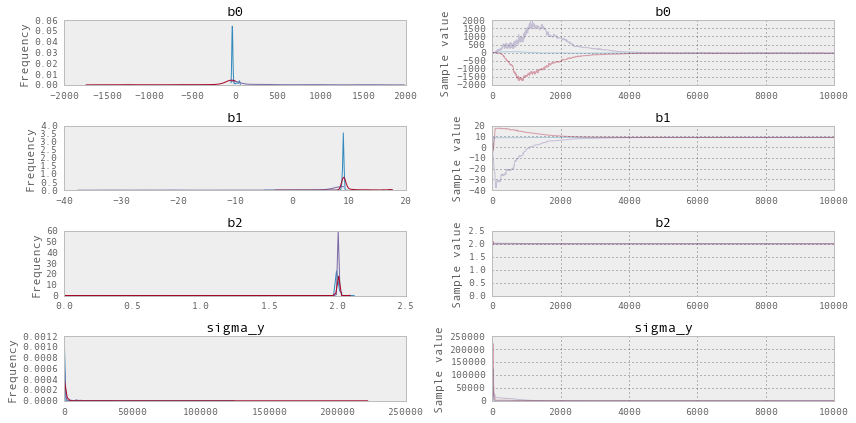

In [7]:
ax = pm.traceplot(trc_met[:], figsize=(12,4*1.5), combined=False)

**Observe:**

+ Great, the model seems reasonably well specified
+ Metropolis, as ever, takes a while to converge

##### View Model Coeffs

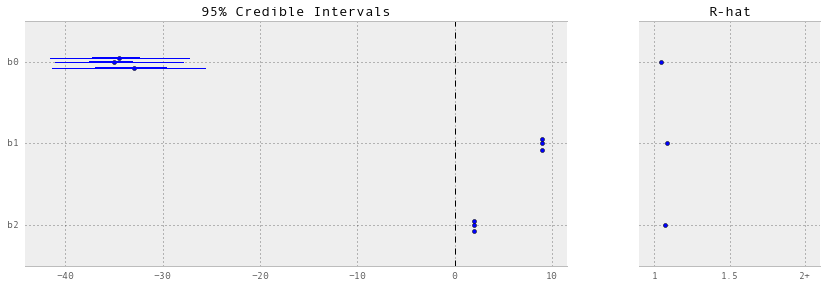

In [8]:
gs = pm.forestplot(trc_met[-1000:], varnames=['b0', 'b1', 'b2'])

**Observe:**

+ This simple model took only 10 sec to sample using Metropolis.
+ Parameter estimates for b1 and b2 seem good, b0 seems a little off, but in general parameters are good.


## ADVI Estimation

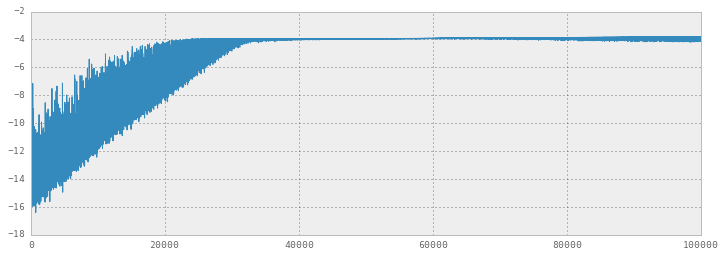

In [9]:
with mdl:
    v_params = pm.variational.advi(n=100000, verbose=False) 

_ = plt.plot(-np.log10(-v_params.elbo_vals))

**Observe:**

+ ADVI takes many iterations to converge for this model, but it gets there in the end
+ NOTE: I've plotted the ELBO on a log scale since the values swept through more than 10 orders of magnitude, and on a linear scale it becomes very hard to see convergence

In [10]:
df_v_means = pd.DataFrame(v_params.means, index=['mean'])
df_v_stds = pd.DataFrame(v_params.stds, index=['std'])
df_v_params = pd.merge(df_v_means.T, df_v_stds.T, left_index=True, right_index=True)
df_v_params

,mean,std
b0,14.491795,18.010402
b1,8.712273,0.019617
b2,2.000189,0.000013
sigma_y_log_,5.872786,0.028040


**Observe:**

+ The fitted parameter values don't look too horrible, but there seems to be an issue with b0 in particular.
+ However, I don't really want to report these values anyhow, instead, I'll use them to parameterise the NUTS sampler.

---

# Test NUTS Sampling

## 1. NUTS initialise MAP at test_point

In [11]:
with mdl:   
    trc_nuts = pm.sample(300, njobs=3, step=pm.NUTS())

 [-----------------100%-----------------] 300 of 300 complete in 9.2 sec

##### View Traces

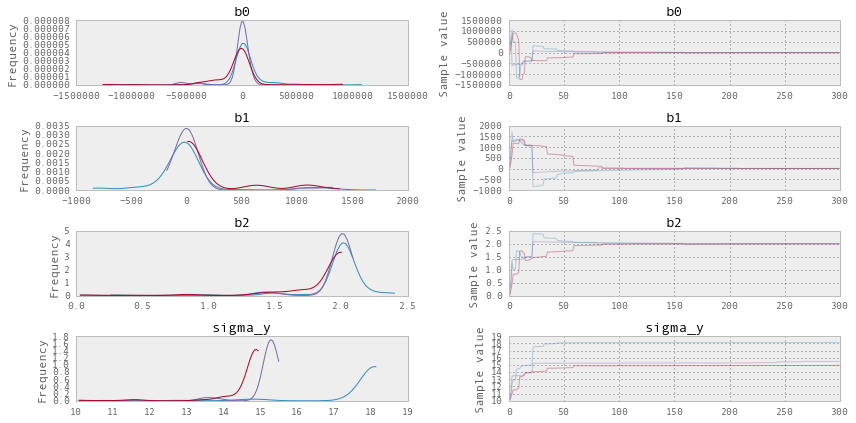

In [12]:
ax = pm.traceplot(trc_nuts[:], figsize=(12,4*1.5), combined=False)

##### View Model Coeffs

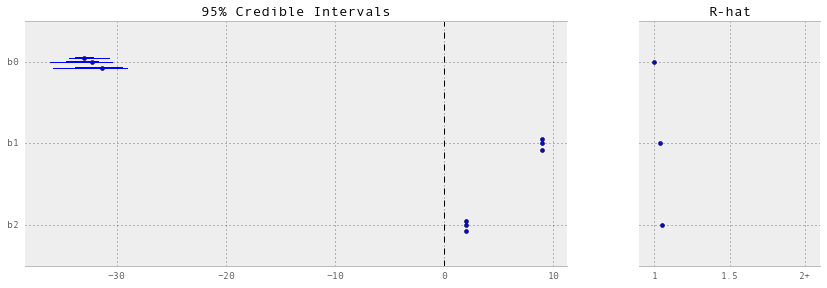

In [13]:
gs = pm.forestplot(trc_nuts[-10:], varnames=['b0', 'b1', 'b2'])

**Observe:**

+ The model took 9.2 sec to sample
+ We didn't hit convergence until after 100 samples, with some slight movement remaining.
+ The estimated model coeffs look pretty good.

## 2. NUTS initialise MAP using ADVI mean

In [14]:
with mdl:
    trc_nuts_map = pm.sample(draws=300, njobs=3, step=pm.NUTS(), start=v_params.means)

 [-----------------100%-----------------] 300 of 300 complete in 163.4 sec

##### View Traces

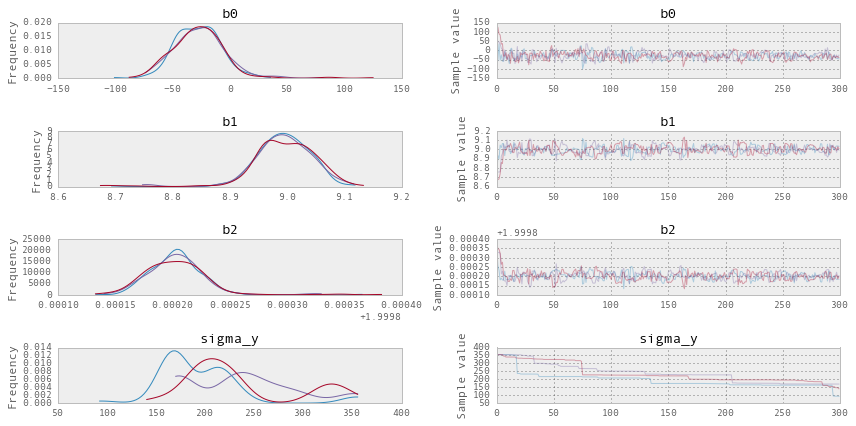

In [15]:
ax = pm.traceplot(trc_nuts_map[:], figsize=(12,4*1.5), combined=False)

##### View Model Coeffs

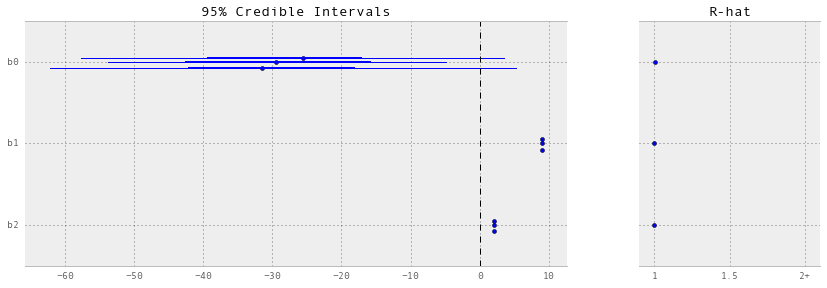

In [16]:
gs = pm.forestplot(trc_nuts_map[-100:], varnames=['b0', 'b1', 'b2'])

**Observe:**

+ The model took 163 sec to sample
+ We hit a sort of convergence quickly after ~50 samples, but the traces afterwards appear to vary a lot - never truly settling.
+ The estimated model coeffs for b1 and b2 look fine, but b0 has a very wide variance.

## 3. NUTS initialise MAP using ADVI mean and scale using ADVI stdevs

In [17]:
with mdl:
    step = pm.NUTS(scaling=np.power(mdl.dict_to_array(v_params.stds),2), is_cov=True)

    trc_nuts_scale = pm.sample(draws=300, njobs=3, step=step, start=v_params.means)

 [-----------------100%-----------------] 300 of 300 complete in 2.8 sec

##### View Traces

In [18]:
def plot_traces(traces, varnames, flatten_chains=False):
    """ Conv fn: plot traces with overlaid means and values """
    
    ax = pm.traceplot(traces, varnames=varnames, figsize=(12,len(varnames)*1.5),
            lines={k: v['mean'] for k, v in pm.df_summary(
                traces, varnames=varnames).iterrows()}, combined=flatten_chains)

    for i, mn in enumerate(pm.df_summary(traces, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

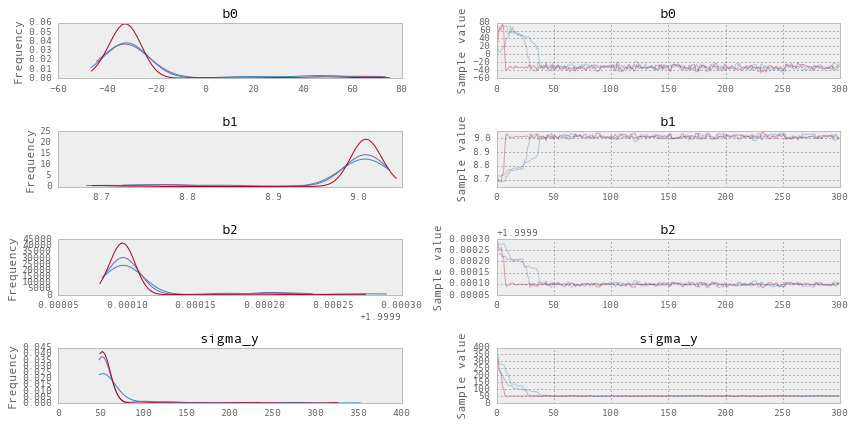

In [19]:
ax = pm.traceplot(trc_nuts_scale, figsize=(12,4*1.5), combined=False)

##### View Model Coeffs

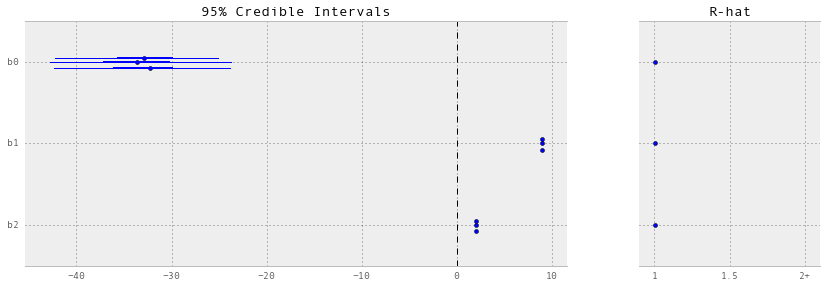

In [20]:
gs = pm.forestplot(trc_nuts_scale[-100:], varnames=['b0', 'b1', 'b2'])

**Observe:**

+ The model took ~3 sec to sample - far quicker than #4 without the scaling, and quicker than #3 initialised at the test point.
+ The traces appear to have converged after ~50 samples, and yielded consistent trace values since: the traces look very settled.
+ The estimated model coeffs look good.

## In Summary

The final estimates of the model parameter coeffs look quite similar, and close to the correct values. Each NUTS sampler was run for the same count of traces, yet they took quite different times to sample, since the quality of exploration was different:

1. NUTS, initialised at test point zero: 9 sec, 
2. NUTS, initialised at mean ADVI: 163 sec
3. NUTS, initialised at mean ADVI, and scaled using ADVI stdevs: 3 sec

The scaling really seems to help speed up the NUTS sampling: the traces appear to converge much more quickly and seem more settled. The parameter estimates are good too.

_**In general, it seems worth trying to set the NUTS scaling using ADVI stdevs.**_


---
Example originally contributed by Jonathan Sedar 2016-10-16   
[github.com/jonsedar](https://github.com/jonsedar)